### Import libraries

In [235]:
import pandas as pd
import optuna
import numpy as np
import matplotlib.pyplot as plt
import shap
import logging
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator
import sklearn.model_selection as ms
from abc import ABC, abstractmethod, ABCMeta
from typing import Final, Type
from tqdm import tqdm
from pandas.errors import ParserError
from random import randint

## Problems for the projects

Answer the questions from the introduction

1) What is leave-one-out? Provide limitations and strengths.
2) How do Grid Search, Randomized Grid Search, and Bayesian optimization work?
3) Explain classification of feature selection methods. Explain how Pearson and Chi2 work. Explain how Lasso works. Explain what permutation significance is. Become familiar with SHAP.


Introduction — do all the preprocessing from the previous lesson

1) Read all the data.
2) Preprocess the "Interest Level" feature.
3) Create features:  'Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'.


Implement the next methods:

1) Split data into 2 parts randomly with parameter test_size (ratio from 0 to 1), return training and test samples.
2) Randomly split data into 3 parts with parameters validation_size and test_size, return train, validation and test samples.
3) Split data into 2 parts with parameter date_split, return train and test samples split by date_split param.
4) Split data into 3 parts with parameters validation_date and test_date, return train, validation and test samples split by input params.


Implement the next cross-validation methods:

1) K-Fold, where k is the input parameter, returns a list of train and test indices.
2) Grouped K-Fold, where k and group_field are input parameters, returns list of train and test indices.
3) Stratified K-fold, where k and stratify_field are input parameters, returns list of train and test indices.
4) Time series split, where k and date_field are input parameters, returns list of train and test indices.


Cross-validation comparison

1) Apply all the validation methods implemented above to our dataset.
2) Apply the appropriate methods from sklearn.
3) Compare the resulting feature distributions for the training part of the dataset between sklearn and your implementation.
4) Compare all validation schemes. Choose the best one. Explain your choice.


Feature Selection

1) Fit a Lasso regression model with normalized features. Use your method for splitting samples into 3 parts by field created with 60/20/20 ratio — train/validation/test.
2) Sort features by weight coefficients from model, fit model to top 10 features and compare quality.
3) Implement method for simple feature selection by nan-ratio in feature and correlation. Apply this method to feature set and take top 10 features, refit model and measure quality.
4) Implement permutation importance method and take top 10 features, refit model and measure quality.
5) Import Shap and also refit model on top 10 features.
6) Compare the quality of these methods for different aspects — speed, metrics and stability.


Hyperparameter optimization

1) Implement grid search and random search methods for alpha and l1_ratio for sklearn's ElasticNet model.
2) Find the best combination of model hyperparameters.
3) Fit the resulting model.
4) Import optuna and configure the same experiment with ElasticNet.
5) Estimate metrics and compare approaches.
6) Run optuna on one of the cross-validation schemes.

## Answers to the questions

### What is leave-one-out? Provide limitations and strengths

```Leave-One-Out Cross-Validation``` - экстремальный случай ```N-Fold Cross-Validation```, при котором *количество фолдов равняется количеству наблюдений в сете данных* (на каждой итерации алгоритма модель обучается на всех данных, кроме одного наблюдения, которое используется для тестирования)

Преимущества:
* На каждой итерации используется почти весь набор данных (то есть обучение происходит близко к полному случаю)
* Является отличным вариантом для маленьких ```dataset```-ов, где каждое измерение является важным (например в медицине, где наблюдения проводить крайне сложно)
* Не требует стратификации, потому что на каждой итерации в тестовую выборку попадает одно лишь измерение
* Низкое смещение (```bias```)

Недостатки и ограничения:
* Высокая вычислительная сложность, поскольку нужно обучать ```n``` моделей почти на всех данных, поэтому не подходит для больших выборок
* Высокая дисперсия метрики, которая оценивает качество модели (на это оказывают влияние выбросы, поскольку на при вычислении метрики на нём, ошибка будет несвойственно большой, не такой, как для средних данных)

### How do Grid Search, Randomized Grid Search, and Bayesian optimization work?

**```Grid Search```**

* Задаётся сетка (```grid```) возможных значений для каждого гиперпараметра (можно представить как тензор нужной размерности)
* Перебираются все возможные комбинации из этой сетки
* Для каждой комбинации обучается модель и оценивается её качество
* Выбирается комбинация с наилучшим качеством

Преимущества:

* Прост в реализации
* Полный перебор гарантирует нахождение лучшей комбинациии в пределах заданной сетки

Недостатки:

* Крайне медленный, особенно если в сетке много гиперпараметров или их значений

**```Randomized Grid Search```**

* Задаются диапазоны или распределения для гиперпараметров
* Вместо полного перебора случайно выбирается ```N``` (это число задаётся как параметр)
* Для каждой случайной комбинации обучается модель и оценивается её качество
* Выбирается лучший вариант из проверенных

Преимущества:

* Гораздо быстрее ```GridSearch```, поскольку проверяет не все комбинации
* Может найти хорошие параметры даже при большом количество возможных комбинаций гиперпараметров

Недостатки:

* Нет гарантии, что найдёт абсолютно лучшую комбинацию гиперпараметров (но часто находит хорошие)

**```Bayesian optimization```**

Оба перечисленных выше подхода имеют одно слабое место, они не учитывают уже полученные взаимосвязи в параметрах. Для устранения этого недостатка были разработаны специальные методы, основанные на теории вероятности. Рассмотрим подробно алгоритм ```TPE``` из библиотеки ```optuna``` на языке ```Python```

Введём условные обозначения:

* x - вектор гиперпараметров $R^n$
* $y = f(x)$ - значение целевой функции для данного набора параметров (например ```loss``` или ```accuracy```)
* $γ$ - квантиль, разделяющий хорошие и плохие испытания

*Алгоритм*:

* Собирается история из ```N``` испытаний, т. е. случайно выбираются ```N``` возможных векторов гиперпараметров из $R^n$, для них обучаются модели и вычисляются метрики оценки качества. В результате составляется множество пар:<br><br>
  &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$D =$ {$(x_1, y_1), ..., (x_N, y_N)$}<br><br>
  где $x_i$ - случайно выбранный набор гиперпараметов, а $y_i$ - значение метрики для обученной на нём модели

* Далее полученное множество сортируется в зависимости от метрики (например для ```accuracy``` в порядке невозрастания, а для ```loss``` в порядке неубывания) и выбирается $Nγ$ лучших точек ($D_{good}$), остальные считаются плохими ($D_{bad}$)

* Следующим шагом является построение распределений $l(x)$ (распредение *"хороших"* точек) и $g(x)$ (распределение *"плохих"* точек) с помощью ядерной оценки<br><br>
&emsp;Ядерная оценка плотности (```KDE```) - способ оценить плотность распределения случайной величины, не предполагая его конкретной формы. Для одномерного случая:<br><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$f(x) = (nh)^{-1}Σ_{i = 1}^{n} K((x - x_i)h^{-1})$<br><br>
  &emsp;где $K$ - неотрицательная симметричная функция, $h$ - ширина полосы (параметр сглаживания), $x$ - точка, в которой оцениваем плотность, $x_i$ - наблюдение из выборки, $n$ - количество наблюдений в выборке

  &emsp;В ```TPE``` используется гауссово ядро (ядро определяет, как каждое наблюдение влияет на оценку плотности в точке ```x```):<br><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$K(u) = 2π^{-1} * e ^ {-u^22^{-1}}$<br><br>
  &emsp;Параметр $h$ контролирует степень сглаживания (фактически выполняет роль среднеквадратичного отклонения $σ$):
    * малое $h$ -> ```KDE``` точно повторяет данные
    * большое $h$ -> ```KDE``` слишком сглажена

  &emsp;В алгоритме ```optuna``` для $h$ используется адаптивный метод (правила Скотта):<br><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$h = σn^{-5^{-1}}$<br><br>
  &emsp;где $σ$ - среднеквадратичное отклонение выборки

  &emsp;То есть мы строим оценку для плотности распределения случайной величины как и в случае гистограммы, НО вместо увеличения высоты столбца мы помещаем в точку $x_i$ влияние от выбранного ядро

  &emsp;Для одномерного случая формула постороения оценки плотности записана выше, только нужно для $l(x)$ заменить $n$ на $|D_{good}|$, для $g(x)$ - на $|D_{good}|$

  &emsp;Для многомерного вектора $x$ в случае независимых гиперпараметров ```KDE``` строится для каждого отдельно, а итоговая плотность - произведение:<br><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$l(x_1, ..., x_k) = ∏_{j=1}^{k}l_j(x_j)$<br><br>
  &emsp;В случае, когда гиперпараметры имеют зависимости, используется многомерное ядро

* Далее в соответствии с критерием выбора следующей точки выбирается вектор $x_{new}$<br><br>
&emsp;При выборе новой точки ```TPE``` максимизирует ```Expected Improvement (EI)```<br><br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$EI(x) = l(x) * g(x)^{-1}$<br><br>
&emsp;Чем выше $EI(x)$, тем лучше (вероятнее) подходит $x$, то есть следующий $x^* = argmax(EI(x))$

* После выбора нового $x^*$, в этой точке обучается модель и алгоритм повторяется сначала, но только теперь множество $x$ расширяется на одну предсказанную точку. Так происходит указанное число раз

### Explain classification of feature selection methods. Explain how Pearson and Chi2 work. Explain how Lasso works. Explain what permutation significance is. Become familiar with SHAP

Первое разбиение методов выполняется на основе того, используется ли столбец целевой переменной или нет:

* ```Unsupervised``` (для выбора признаков не используется целевую переменную)
* ```Supervised``` (использует целевую переменную для выбора признаков)

Далее ```Supervised``` методы делятся на три группы:

* ```Wrappers``` (```wrap``` - *оборачивать*): эти методы названы так, потому что они оборачивают процесс обучения модели, используя её как черный ящик для оценки качества подмножеств признаков
* ```Filters```: эта группа методов названа так, потому что они отбирают признаки ДО обучения модели, используя статистические критерии для "фильтрации" признаков
* ```Embedded``` (*встроенные*): названы так, потому что отбор признаков встроен непосредственно в процесс обучения модели (эти методы используют внутренние механизмы алгоритма для определения важности признаков)

**```Pearson's r```** (коэффициент корреляции Пирсона)

С помощью этого коэффициента измеряется степень линейной зависимости между двумя случайными величинами

Используется для отбора признаков, наиболее коррелированных (линейно зависимых) с целевой переменной

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$r = \frac{Cov(X, Y)}{σ_X σ_Y}$<br>

где $Cov$ - ковариация двух случайных величин, $X$ - признак, $Y$ - целевая переменная, $σ_X$ и $σ_Y$ - их среднеквадратичные отклонения

Как следует из неравенства Коши-Буняковского-Шварца: $|r| <= 1$

При $r$ близких к $1$, признак считается важным, потому что тогда он почти линейно зависим с целевой переменной

**```Chi2```** (критерий Хи-квадрат)

Статистический метод, который позволяет проверить, существует ли значимая зависимость между двумя категориальными случайными величинами 

Используется для отбора признаков в задачах классификации, помогая определить, какие категориальные признаки наиболее сильно связаны с целевой переменной

Поскольку это критерий, то он подразумевает 2 гипотезы:

* $H_0$ - величины независимы
* $H_1$ - между величинами существует связь

***Как использовать этот критерий?***

1) *Построение таблицы сопряжённости*. Пример:<br>

Пусть признак $X$ - курение (да/нет), целевая переменная $Y$ - рак лёгких (болен/здоров). Тогда таблица будет выглядеть так:<br><br>
&emsp;&emsp;&emsp;&emsp;**Болен($Y=1$)**&emsp;**Здоров($Y=0$)**<br>
**Курит**&emsp;&emsp;&emsp; $30$ ($O_{11}$)&emsp;&emsp;&emsp;&emsp; $10$ ($O_{12}$) <br>
**Не курит**&emsp;&emsp; $5$ ($O_{21}$)&emsp;&emsp;&emsp;&emsp; $55$ ($O_{22}$)

2) *Вычисление ожидаемых частот* ($E_{ij}$)

Ожидаемая частота ($E_{ij}$) - это ожидаемое количество наблюдений в ячейке $(i, j)$ таблицы сопряженности при условии, что категориальные переменные независимы

Очевидно, что если две случайные величины категориальные, то у них конечное число возможных значений. Тогда мы, зная их таблицу смежности, можем оценить распределение случайных величин ($X$ и $Y$), т. е. вероятности того, что $X = k$ в очередном испытании (для каждого возможного $k$)

Эти вероятности вычисляются так:

$P_{Y=k} = \frac{Σ_{i=1}^{m} O_{ik}}{l}$

$P_{X=k} = \frac{Σ_{i=1}^{n} O_{ki}}{l}$ 

И тогда предполагая, что случайные величины независимы, можно понять ожидаемое их количество появлений в клетке $(i, j)$ таблицы смежности, оно рассчитывается по формуле:

$E_{ij} = P_{Y=i}  *  P_{X=j}  *  l$

Или, раскрывая эту формулу и сокращая одно $l$ в знаминателе:

$E_{ij} = \frac{Σ_{i=1}^{m} O_{ik} Σ_{i=1}^{n} O_{ki}}{l}$

3) *Вычисление значения статистики* $χ^2$

$χ^2 = Σ_{i=1}^{m} Σ_{j=1}^{n} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$

4) *Проверка уровня значимости*

Далее вычисляется степень свободы ```df``` = ```(Число строк - 1) * (Число столбцов - 1)```

И выбирается уровень значимости $α$ (ошибка $I$ рода) (вероятность того, что верна гипотеза $H_1$ при условии, что верна $H_0$)

После определения подходящих для нашей задачи параметров, нужно взять критическое значение $χ^2$ из специальных таблиц и если полученная нами на предыдущем шаге величина $>$ этого значения, то **зависимость между величинами значительная**<br><br>

Для отбора признаков с помощью этого критерия необходимо сделать следующее:

1) Вычислить $χ^2$ для каждого категориального признака
2) Проранжировать признаки по убыванию $χ^2$
3) Выбрать первые ```N``` признаков

**```Lasso```**

Чтобы понять, почему добавление ```L1``` нормы к функции потерь при обучении линейной модели способствует отбору признаков. Можно показать, что, если решается задача $Q(w, X) + λ ||w||_1$ -> ```min```, то она эквивалентна:

$Q(w, X)$ -> ```min``` и $||w||_1 <= c$, где $c$ - некоторая константа

Если рассмотреть подробнее условие $2$ на ```L1``` норму вектора коэффициентов ```w```, то можно понять, что оно определяет в $R^n$ многомерный ромб

Для $n = 3$:

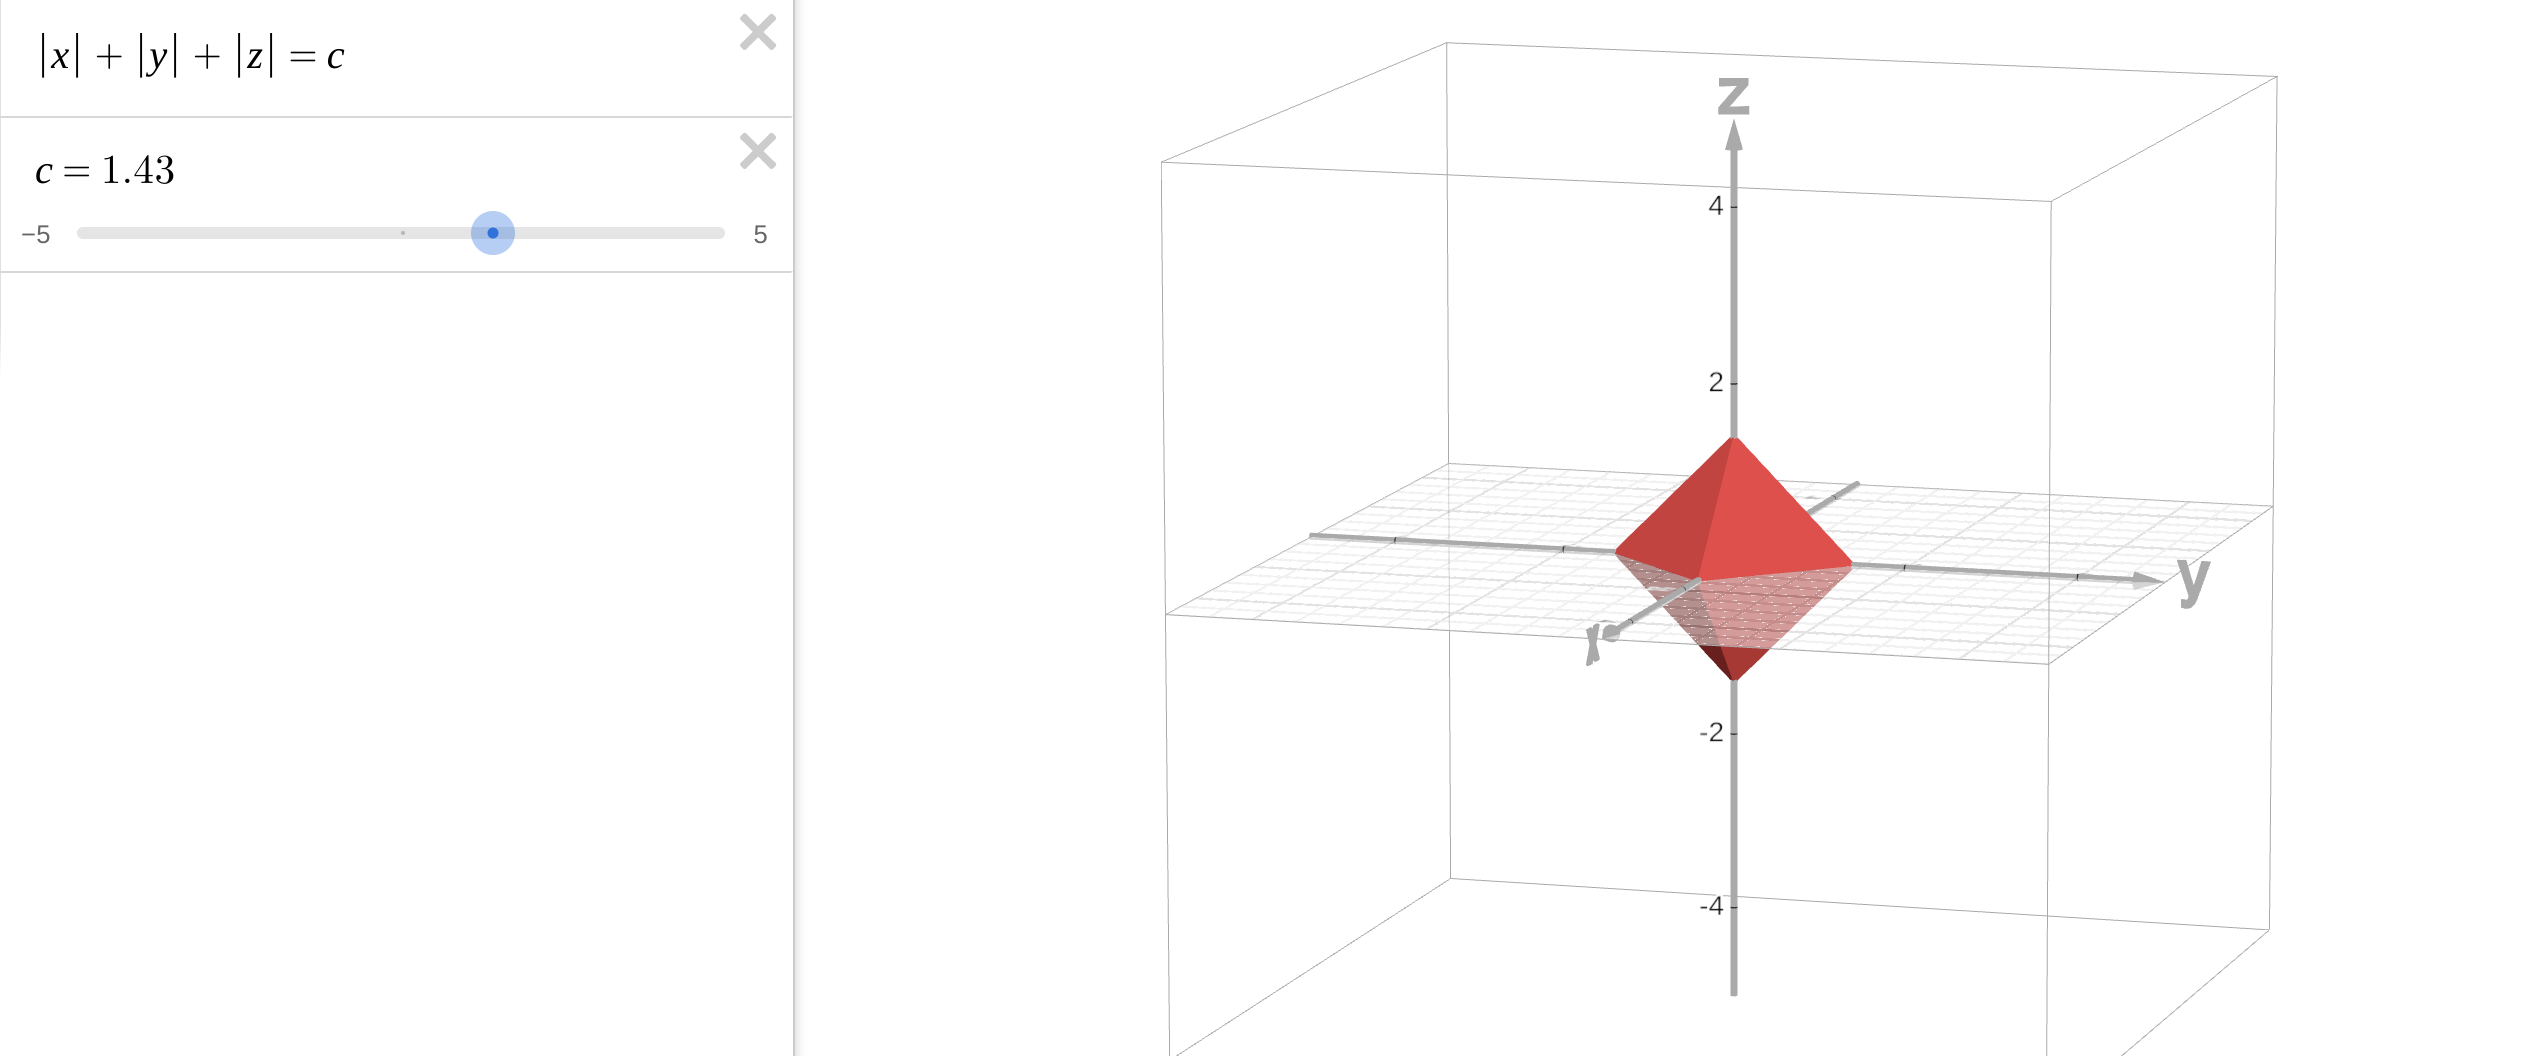

Тогда получается, что нужно найти точку ```w```, лежащую внутри ромба и для которой $Q(w, X)$ минимально

Теперь можно рассмотреть линии уровня функции $Q(w, X)$. Для наглядности можно привести пример в случае, когда $n = 2$:

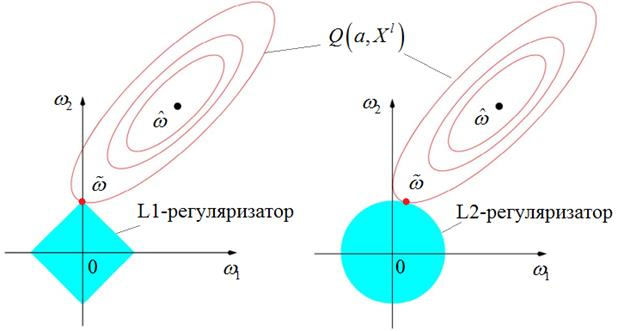

Из фотографии видно, что, скорее всего, линия уровня $Q(w, X)$ пересеклась бы с ромбом в одной из его вершин (или на какой-нибудь границе ромба), где некоторые $w_i$ компоненты вектора ```w``` будут равны $0$

То есть в процессе обучения модель сама обнулила некоторые признаки, а значит они не являются важными и не нужны для её работы

Именно таким образом выполняется отбор признаков при ```Lasso``` регуляризации

**```Permutation significance```**

Это метод отбора признаков, который поочерёдно оценивает значимость каждого с помощью перемешивания значений в столбце

**Алгоритм**:
1) Обучается модель (на всех данных) и вычисляется исходная метрика (```accuracy```, ```f1-score```...)
2) Для каждого признака:<br>
&emsp;* значения этого признака в данных перемешиваются, что разрушает связь с целевой переменной<br>
&emsp;* модель делает предсказания на изменённых данных и вычисляется новая метрика<br>
&emsp;* ```важность признака = исходная метрика - новая метрика```
3) Признаки сортируются по убыванию важности метрики

## Data preprocessing

In [128]:
data = pd.read_json(path_or_buf="./data/train.json", convert_dates=["created"], orient="columns")
data.reset_index(drop=True, inplace=True)

In [129]:
category_to_num = {"low": 0, "medium": 1, "high": 2}

data["interest_level"] = data["interest_level"].map(category_to_num)

data.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0


In [130]:
class DataCleaner:
    __slots__ = ('__sep',)
    
    def __init__(self, sep: tuple[str, ...]):
        self.sep = sep
    
    def __call__(self, df: pd.DataFrame, column_name: str, *args, **kwargs):
        if not type(column_name) is str:
            raise TypeError("Incorrect type for 'column_name' argument")
        if not type(df) is pd.DataFrame:
            raise TypeError("Incorrect type for 'df' argument")

        df[column_name] = df[column_name].apply(lambda lst: [x.translate(self.sep) for x in lst])

    @property
    def sep(self):
        return self.__sep

    @sep.setter
    def sep(self, sep):
        if not type(sep) is tuple or any(not type(x) is str or len(x) != 1 for x in sep):
            raise TypeError("Incorrect type or values for 'sep' argument")

        self.__sep = str.maketrans("", "", "".join(sep))

In [131]:
sep = (',', ' ')

cleaner = DataCleaner(sep)
cleaner(data, 'features')

data.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[DiningRoom, Pre-War, LaundryinBuilding, Dishw...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, LaundryinBuilding, Dishwas...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0


In [132]:
categories = {'Elevator', 'CatsAllowed', 'HardwoodFloors', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding',
              'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony',
              'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace'}

data["features"] = data["features"].apply(lambda x: [item for item in x if item in categories]) # очищаем данные от лишних категорий

binarizer = MultiLabelBinarizer(classes=list(categories)) # аналог OneHotEncoder, но в случае, когда в столбце списки признаков
encoded_data = binarizer.fit_transform(data["features"])

encoded_df = pd.DataFrame(encoded_data, columns=binarizer.classes_)

data = pd.concat([encoded_df, data[["interest_level", "bathrooms", "bedrooms", "created", "price"]]], axis=1) # !!! добавлен 'created' !!!

data.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,0,0,0,1,0,0,1,1,1,0,...,1,0,1,0,0,1,1.0,1,2016-06-16 05:55:27,2400
1,1,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,1.0,2,2016-06-01 05:44:33,3800
2,1,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,1,1.0,2,2016-06-14 15:19:59,3495


## Implementing split methods

In [133]:
class SplitterInN:
    __slots__ = ('_n', '_ratios')
    
    def __init__(self, n: int = 2, ratios: list[float] = None, **kwargs):
        self.n = n

        if ratios is None:
            ratios = []

            if 'validation_size' in kwargs:
                ratios.append(kwargs['validation_size'])

            if 'test_size' in kwargs:
                ratios.append(kwargs['test_size'])

        self.ratios = ratios

    def __call__(self, df: pd.DataFrame, *args, **kwargs) -> tuple[pd.DataFrame, ...]:
        if not type(df) is pd.DataFrame:
            raise TypeError("Incorrect type for 'df' argument")

        df_len = len(df)
        indices = np.random.permutation(df_len) # перемешиваются число от нуля до df_len - 1

        lens = [int(self.ratios[i] * df_len) for i in range(self.n - 1)]
        lens.insert(0, df_len - sum(lens))

        splits = np.split(indices, np.cumsum(lens)[:-1]) # разбивает исходный массив по индексам, указанным вторым аргументом
        samples = tuple(df.iloc[split] for split in splits) # с помощью .iloc получаем нужные строки из данных

        for df in samples:
            df.reset_index(drop=True, inplace=True)

        return samples

    @property
    def ratios(self):
        return self._ratios

    @ratios.setter
    def ratios(self, ratios):
        if not ratios is None:
            if not type(ratios) is list:
                raise TypeError("Parameter 'ratios' must be a list")
            elif any(not (0 < x < 1) for x in ratios):
                raise ValueError("All ratios must be between 0 and 1")
            elif sum(ratios) > 1:
                raise ValueError("Sum of ratios must be less than 1")
            elif len(ratios) + 1 != self.n:
                raise ValueError("Amount of ratios must be n-1")

        self._ratios = ratios

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        if not type(n) is int:
            raise TypeError("Parameter 'n' must be an integer")
        elif n < 2:
            raise ValueError("Parameter 'n' must be at least 2")

        self._n = n

In [134]:
class DateSplitterInN:
    __slots__ = ("_n", "_dates")
    
    def __init__(self, n: int = 2, dates: list = None, **kwargs):
        self.n = n

        if dates is None:
            dates = []

            if "validation_date" in kwargs:
                dates.append(kwargs["validation_date"])
            
            if "test_date" in kwargs or "date_split" in kwargs:
                dates.append(kwargs["test_date" if "test_date" in kwargs else "date_split"])

        self.dates = dates

    def __call__(self, df: pd.DataFrame, column_name: str, is_sorted: bool = False, *args, **kwargs) -> tuple[pd.DataFrame, ...]:
        if not type(df) is pd.DataFrame:
            raise TypeError("Parameter 'df' must be a pandas.DataFrame")
        if not type(column_name) is str:
            raise TypeError("Parameter 'column_name' must be a string")
        if not type(is_sorted) is bool:
            raise TypeError("Parameter 'is_sorted' must be a bool")

        if not is_sorted:
            df = df.sort_values(by=column_name)

        if df.iloc[0][column_name] > self.dates[-1] or df.iloc[-1][column_name] < self.dates[0]:
            raise ValueError("Dates don't overlap")

        samples = [df[df[column_name] < self.dates[0]].copy()]
        if self.n > 2:
            samples += [df[(self.dates[i - 1] < df[column_name]) & (df[column_name] < self.dates[i])].copy() for i in range(1, self.n - 1)]
        samples.append(df[df[column_name] > self.dates[-1]].copy())

        for sample in samples:
            sample.reset_index(drop=True, inplace=True)

        return samples

    @property
    def dates(self):
        return self._dates

    @dates.setter
    def dates(self, dates):
        if not dates is None:
            if not type(dates) is list:
                raise TypeError("Parameter 'dates' must be a list")
            elif len(dates) + 1 != self.n:
                raise ValueError("Length of 'dates' must be n-1")

        try:
            dates = [pd.to_datetime(date) for date in dates]
        except ParserError:
            raise ValueError("Unknown datetime string format in 'dates'")

        if any(dates[i - 1] > dates[i] for i in range(1, self.n - 1)):
            raise ValueError("Dates must be arranged in chronological order")

        self._dates = dates

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        if not type(n) is int:
            raise TypeError("Parameter 'n' must be an integer")
        elif n < 2:
            raise ValueError("Parameter 'n' must be at least 2")

        self._n = n

## Implementing cross-validation methods

In [135]:
class BaseCrossValidation(ABC):
    @abstractmethod
    def __call__(self, *args, **kwargs) -> tuple[tuple[np.ndarray, np.ndarray], ...]:
        pass

    @property
    @abstractmethod
    def k(self, k):
        pass

In [136]:
class KFold(BaseCrossValidation):
    __slots__ = ("_k", )
    
    def __init__(self, k: int = 5):
        self.k = k

    def __call__(self, df: pd.DataFrame, *args, **kwargs) -> tuple[tuple[np.ndarray, np.ndarray], ...]:
        if not type(df) is pd.DataFrame:
            raise TypeError("Parameter 'df' must be a pandas.DataFrame")

        df_len = len(df)
        fold_size = df_len // self.k
        mod = df_len - fold_size * self.k
        lens = [fold_size + int(i < mod) for i in range(self.k)]

        indices = np.random.permutation(df_len)
        splits = np.split(indices, np.cumsum(lens)[:-1])
        
        return tuple((np.concatenate(splits[:i] + splits[i + 1:]), splits[i]) for i in range(self.k))

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, k):
        if not type(k) is int:
            raise TypeError("Parameter 'k' must be an integer")
        elif k < 2:
            raise ValueError("Parameter 'k' must be at least 2")

        self._k = k

In [137]:
class GroupKFold(BaseCrossValidation):
    __slots__ = ("_k", "_group_field")
    
    def __init__(self, group_field: str, k: int = 5):
        self.k = k
        self.group_field = group_field

    def __call__(self, df: pd.DataFrame, *args, **kwargs) -> tuple[tuple[np.ndarray, np.ndarray], ...]:
        if not type(df) is pd.DataFrame:
            raise TypeError("Parameter 'df' must be a pandas.DataFrame")

        if not self.group_field in df.columns:
            raise ValueError(f"df doesn't contain {self.group_field} column")

        counts = df[self.group_field].value_counts()

        if len(counts) < self.k:
            raise ValueError(f"Groups in {self.group_field} less than folds")

        counts.sort_values(ascending=False, inplace=True)
        groups = set(counts.index.values)
        folds, fold_sizes = [set() for _ in range(self.k)], [0 for _ in range(self.k)]

        for group, size in counts.items():
            min_fold = np.argmin(fold_sizes)

            folds[min_fold].add(group)
            fold_sizes[min_fold] += size

        return tuple(
            (df[df[self.group_field].isin(groups - folds[i])].index.values,
             df[df[self.group_field].isin(folds[i])].index.values)
            for i in range(self.k))

    @property
    def group_field(self):
        return self._group_field

    @group_field.setter
    def group_field(self, group_field):
        if not type(group_field) is str:
            raise TypeError("Parameter 'group_field' must be a string")

        self._group_field = group_field

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, k):
        if not type(k) is int:
            raise TypeError("Parameter 'k' must be an integer")
        elif k < 2:
            raise ValueError("Parameter 'k' must be at least 2")

        self._k = k

In [138]:
class StratifiedKFold(BaseCrossValidation):
    __slots__ = ('_stratify_field', '_k')
    
    def __init__(self, stratify_field: str, k: int = 5):
        self.stratify_field = stratify_field
        self.k = k

    def __call__(self, df: pd.DataFrame, *args, **kwargs) -> tuple[tuple[np.ndarray, np.ndarray], ...]:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Parameter 'df' must be a pandas.DataFrame")

        if not self.stratify_field in df.columns:
            raise ValueError(f"df doesn't contain {self.stratify_field} column")

        classes = df[self.stratify_field].unique()
        samples = [([], []) for _ in range(self.k)]
        for cls in classes:
            curr_df = df[df[self.stratify_field] == cls]

            df_len = len(curr_df)
            fold_size = df_len // self.k
            mod = df_len - fold_size * self.k
            lens = [fold_size + int(i < mod) for i in range(self.k)]

            indices = np.random.permutation(df_len)
            splits = np.split(indices, np.cumsum(lens)[:-1])

            for i in range(self.k):
                train_indices = np.concatenate(splits[:i] + splits[i + 1:])
                test_indices = splits[i]
                samples[i][0].append(train_indices)
                samples[i][1].append(test_indices)

        return tuple(
            (np.concatenate(samples[i][0]), np.concatenate(samples[i][1]))
            for i in range(self.k)
        )

    @property
    def stratify_field(self):
        return self._stratify_field

    @stratify_field.setter
    def stratify_field(self, stratify_field):
        if not isinstance(stratify_field, str):
            raise TypeError("Parameter 'stratify_field' must be a string")

        self._stratify_field = stratify_field

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, k):
        if not type(k) is int:
            raise TypeError("Parameter 'k' must be an integer")
        elif k < 2:
            raise ValueError("Parameter 'k' must be at least 2")

        self._k = k

In [139]:
class TimeSeriesSplit(BaseCrossValidation):
    __slots__ = ("_k", "_date_field")
    
    def __init__(self, date_field: str, k: int = 5):
        self.k = k
        self.date_field = date_field

    def __call__(self, df: pd.DataFrame, is_sorted: bool, *args, **kwargs) -> tuple[tuple[np.ndarray, np.ndarray], ...]:
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Parameter 'df' must be a pandas.DataFrame")
        if not isinstance(is_sorted, bool):
            raise TypeError("Parameter 'is_sorted' must be a bool")
        if not self.date_field in df.columns:
            raise ValueError(f"df doesn't contain {self.date_field} column")

        if not is_sorted:
            df = df.sort_values(by=self.date_field)

        indices, df_len = df.index.values, len(df)
        fold_size = df_len // self.k
        mod = df_len - fold_size * self.k
        lens = [fold_size + int(i < mod) for i in range(self.k)]

        splits = np.split(indices, np.cumsum(lens)[:-1])
        samples = [([], []) for _ in range(self.k - 1)]
        for i in range(1, self.k):
            samples[i - 1][0].append(np.concatenate(splits[:i]))
            samples[i - 1][1].append(splits[i])
        
        return tuple(
            (np.concatenate(samples[i][0]), 
             samples[i][1][0]) for i in range(self.k - 1)
        )

    @property
    def date_field(self):
        return self._date_field

    @date_field.setter
    def date_field(self, date_field):
        if not isinstance(date_field, str):
            raise TypeError("Parameter date_field must be a string")

        self._date_field = date_field

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, k):
        if not type(k) is int:
            raise TypeError("Parameter 'k' must be an integer")
        elif k < 2:
            raise ValueError("Parameter 'k' must be at least 2")

        self._k = k

## Cross-validation comparison

In [140]:
v1 = SplitterInN(test_size=0.2)

X_train_1, X_test_1 = v1(data)

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(X_train_1)};\nДлина тестовой выборки: {len(X_test_1)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 39482;
Длина тестовой выборки: 9870.


In [141]:
X_train_1.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,1,0,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1.0,0,2016-04-22 03:56:56,3500
1,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1.0,1,2016-06-09 01:12:27,2350
2,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1.0,1,2016-04-28 03:41:05,2395


In [142]:
v2 = SplitterInN(3, test_size=0.15, validation_size=0.2)

X_train_2, X_validation_2, X_test_2 = v2(data)

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(X_train_2)};\nДлина тестовой выборки: {len(X_test_2)};\nДлина валидационного множества: {len(X_validation_2)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 32080;
Длина тестовой выборки: 7402;
Длина валидационного множества: 9870.


In [143]:
X_validation_2.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1.0,1,2016-05-17 04:59:12,2450
1,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,2.0,2,2016-05-21 03:14:05,3900
2,1,0,1,1,0,0,1,1,0,0,...,0,0,0,0,0,0,3.0,3,2016-05-05 03:17:28,13500


In [144]:
v3 = DateSplitterInN(date_split="2016-05-03")

X_train_3, X_test_3 = v3(data, "created")

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(X_train_3)};\nДлина тестовой выборки: {len(X_test_3)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 16766;
Длина тестовой выборки: 32586.


In [145]:
X_test_3.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.0,3,2016-05-03 01:01:18,2850
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.0,3,2016-05-03 01:01:18,2400
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.5,3,2016-05-03 01:01:50,2999


In [146]:
v4 = DateSplitterInN(3, validation_date="2016-05-03", test_date="2016-06-03")

X_train_4, X_validation_4, X_test_4 = v4(data, "created")

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(X_train_4)};\nДлина тестовой выборки: {len(X_test_4)};\nДлина валидационного множества: {len(X_validation_4)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 16766;
Длина тестовой выборки: 15486;
Длина валидационного множества: 17100.


In [147]:
X_validation_4

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.0,3,2016-05-03 01:01:18,2850
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.0,3,2016-05-03 01:01:18,2400
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1.5,3,2016-05-03 01:01:50,2999
3,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1.0,1,2016-05-03 01:02:00,2040
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,0,2016-05-03 01:10:39,1925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,2,2016-06-02 21:23:15,3200
17096,0,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,2.0,2,2016-06-02 21:49:35,3398
17097,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,1,2016-06-02 22:00:59,3695
17098,1,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,1.0,0,2016-06-02 22:17:48,2400


In [148]:
def show_length_KF(indices: tuple):
    print(f"Распределение количества индексов:\n")
    for i in range(K):
        print(f"Длина текущего фолда: {len(indices[i][1])};\nДлина обучающей выборки для этого фолда: {len(indices[i][0])}.", end="\n\n")

In [149]:
def sklearn_show_length_KF(indices):
    print(f"Распределение количества индексов:\n")
    for curr_indices in indices:
        print(f"Длина текущего фолда: {len(curr_indices[1])};\nДлина обучающей выборки для этого фолда: {len(curr_indices[0])}.", end="\n\n")

In [150]:
K: Final = 3

v5 = KFold(k=K)
indices_5 = v5(data)

show_length_KF(indices_5)

Распределение количества индексов:

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.



In [151]:
data.iloc[indices_5[1][1]].head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
43544,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1.0,2,2016-04-21 01:24:30,1850
23863,0,0,1,1,0,0,1,1,1,0,...,0,0,1,0,0,0,1.0,1,2016-05-10 05:56:06,2350
24674,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,1,2016-05-10 02:13:46,4130


In [152]:
v6 = GroupKFold(k=K, group_field="bedrooms")
indices_6 = v6(data)

show_length_KF(indices_6)

print(f"Количество спален для объектов обучающей выборки во 2-ом фолде: {data.iloc[indices_6[1][1]]["bedrooms"].unique()}")
print(f"Количество спален для объектов тестовой выборки во 2-ом фолде: {data.iloc[indices_6[1][0]]["bedrooms"].unique()}")

Распределение количества индексов:

Длина текущего фолда: 16049;
Длина обучающей выборки для этого фолда: 33303.

Длина текущего фолда: 16552;
Длина обучающей выборки для этого фолда: 32800.

Длина текущего фолда: 16751;
Длина обучающей выборки для этого фолда: 32601.

Количество спален для объектов обучающей выборки во 2-ом фолде: [2 4]
Количество спален для объектов тестовой выборки во 2-ом фолде: [1 3 0 5 6 8 7]


In [153]:
v7 = StratifiedKFold(k=K, stratify_field="interest_level")
indices_7 = v7(data)

show_length_KF(indices_7)

print(data.iloc[indices_7[2][1]]["interest_level"].value_counts())
print(data.iloc[indices_7[2][0]]["interest_level"].value_counts())

Распределение количества индексов:

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.

interest_level
0    11578
1     3606
2     1266
Name: count, dtype: int64
interest_level
0    22785
1     7553
2     2564
Name: count, dtype: int64


In [154]:
v8 = TimeSeriesSplit(k=K, date_field="created")
indices_8 = v8(data, is_sorted=False)

print(f"Распределение количества индексов:\n")
for i in range(K - 1):
    print(f"Длина текущего фолда: {len(indices_8[i][1])};\nДлина обучающей выборки для этого фолда: {len(indices_8[i][0])}.", end="\n\n")

Распределение количества индексов:

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 16451.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.



In [155]:
data.iloc[indices_8[1][1]]

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
4923,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1.0,0,2016-06-01 05:59:07,2400
13553,1,1,1,0,1,1,0,1,0,0,...,0,0,0,0,1,0,1.0,3,2016-06-01 05:59:24,4500
10895,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1.0,2,2016-06-01 05:59:35,3450
6812,0,0,1,0,0,0,1,1,1,0,...,0,1,1,1,0,0,1.0,2,2016-06-01 05:59:36,2199
13741,1,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,1,2.0,4,2016-06-01 05:59:50,4995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.0,2,2016-06-29 17:47:34,3045
10444,0,0,1,0,0,1,0,0,1,0,...,0,1,1,0,0,0,1.0,1,2016-06-29 17:56:12,2648
247,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1.0,1,2016-06-29 18:14:48,2650
13840,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1.0,3,2016-06-29 18:30:41,3200


In [156]:
sk_X_train_1, sk_X_test_1 = ms.train_test_split(data, test_size=0.2)

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(sk_X_train_1)};\nДлина тестовой выборки: {len(sk_X_test_1)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 39481;
Длина тестовой выборки: 9871.


In [157]:
sk_X_train_2, sk_X_test_2 = ms.train_test_split(data, test_size=0.15)
sk_X_train_2, sk_X_validation_2 = ms.train_test_split(sk_X_train_2, test_size=0.2353)

print(f"Длина исходного сета: {len(data)};\nДлина обучающей выборки: {len(sk_X_train_2)};\nДлина тестовой выборки: {len(sk_X_test_2)};\nДлина валидационного множества: {len(sk_X_validation_2)}.")

Длина исходного сета: 49352;
Длина обучающей выборки: 32078;
Длина тестовой выборки: 7403;
Длина валидационного множества: 9871.


<br><br>Для разделения по датам **встроенных в** ```sklearn``` **методов нет**, оно и не нужно, поскольку это можно легко сделать с помощью маскирования и инструментов ```pandas```<br><br>

In [158]:
sk_v5 = ms.KFold(n_splits=K)
sk_indices_5 = sk_v5.split(data)

sklearn_show_length_KF(sk_indices_5)

Распределение количества индексов:

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.



In [159]:
sk_v6 = ms.GroupKFold(n_splits=K)
sk_indices_6 = sk_v6.split(data.iloc[:, :(-1)], data.iloc[:, -1], groups=data["bedrooms"].values)

sklearn_show_length_KF(sk_indices_6)

sk_indices_6 = sk_v6.split(data.iloc[:, :(-1)], data.iloc[:, -1], groups=data["bedrooms"].values)
for i, indices in enumerate(sk_indices_6):
    if i == 1:
        print(f"Количество спален для обучающей выборки во 2-ом фолде: {data.iloc[indices[0]]["bedrooms"].unique()}")
        print(f"Количество спален для тестовой выборки во 2-ом фолде: {data.iloc[indices[1]]["bedrooms"].unique()}")

Распределение количества индексов:

Длина текущего фолда: 16049;
Длина обучающей выборки для этого фолда: 33303.

Длина текущего фолда: 16552;
Длина обучающей выборки для этого фолда: 32800.

Длина текущего фолда: 16751;
Длина обучающей выборки для этого фолда: 32601.

Количество спален для обучающей выборки во 2-ом фолде: [1 3 0 5 6 8 7]
Количество спален для тестовой выборки во 2-ом фолде: [2 4]


In [160]:
sk_v7 = ms.StratifiedKFold(n_splits=K)
sk_indices_7 = sk_v7.split(data, data["interest_level"])

sklearn_show_length_KF(sk_indices_7)

sk_indices_7 = sk_v7.split(data, data["interest_level"])
for i, indices in enumerate(sk_indices_7):
    if i == 2:
        print(data.iloc[indices[0]]["interest_level"].value_counts(), end="\n\n")
        print(data.iloc[indices[1]]["interest_level"].value_counts())

Распределение количества индексов:

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16451;
Длина обучающей выборки для этого фолда: 32901.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.

interest_level
0    22856
1     7486
2     2560
Name: count, dtype: int64

interest_level
0    11428
1     3743
2     1279
Name: count, dtype: int64


In [161]:
sk_v8 = ms.TimeSeriesSplit(n_splits=(K - 1))
sk_indices_8 = sk_v8.split(data.copy().sort_values("created"))

print(f"Распределение количества индексов:\n")
for curr_indices in sk_indices_8:
    print(f"Длина текущего фолда: {len(curr_indices[1])};\nДлина обучающей выборки для этого фолда: {len(curr_indices[0])}.", end="\n\n")

Распределение количества индексов:

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 16452.

Длина текущего фолда: 16450;
Длина обучающей выборки для этого фолда: 32902.



<br><br>

При сравнении результатов разбиений прежде всего будут учитываться длины получившихся выборок (или фолдов), поскольку все собственные реализации алгоритмов перемешивают данные перед разделением и сравнивать их по составу не имеет смысла:

1) **```Разделение на две части:```**

```Peer's version```:

Длина исходного сета: 49352;<br>
Длина обучающей выборки: 39482;<br>
Длина тестовой выборки: 9870.<br><br>

```sklearn version```:

Длина исходного сета: 49352;<br>
Длина обучающей выборки: 39481;<br>
Длина тестовой выборки: 9871.<br><br>

**Комментарий**: как видно, выборки отличаются одно измерение, что связано *с разными подходами к округлению* в случае, когда данные не могут быть разбиты в нужной пропорции нацело

2) **```Разделение на три части:```**

```Peer's version```:

Длина исходного сета: 49352;<br>
Длина обучающей выборки: 32080;<br>
Длина тестовой выборки: 7402;<br>
Длина валидационного множества: 9870.<br><br>

```sklearn version```:

Длина исходного сета: 49352;<br>
Длина обучающей выборки: 32078;<br>
Длина тестовой выборки: 7403;<br>
Длина валидационного множества: 9871.<br><br>

**Комментарий**: снова возникает небольшое отличие на одно измерение в валидационном и тестовом наборе, связанное с тем, что в алгоритмах по-разному реализовано округление

3) **```Разделение на две части с учётом времени```**

**Комментарий**: сравнение не может быть выполнено, поскольку в ```sklearn``` отсутствует подобный метод

4) **```Разделение на три части с учётом времени```**

**Комментарий**: сравнение не может быть выполнено, поскольку в ```sklearn``` отсутствует подобный метод

5) **```KFold```**

```Peer's version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

```sklearn version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

**Комментарий**: количество объектов в каждом из фолдов точно совпадает с их количеством в реализации ```sklearn```, однако в библиотечной реализации без указания параметра ```shuffle``` данные автоматически не будут перемешаны

6) **```GroupKFold```**

```Peer's version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16049;<br>
Длина обучающей выборки для этого фолда: 33303.<br><br>
Длина текущего фолда: 16552;<br>
Длина обучающей выборки для этого фолда: 32800.<br><br>
Длина текущего фолда: 16751;<br>
Длина обучающей выборки для этого фолда: 32601.<br><br>
Количество спален для объектов обучающей выборки во 2-ом фолде: [2 4]<br>
Количество спален для объектов тестовой выборки во 2-ом фолде: [1 3 0 5 6 8 7]<br><br>

```sklearn version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16049;<br>
Длина обучающей выборки для этого фолда: 33303.<br><br>
Длина текущего фолда: 16552;<br>
Длина обучающей выборки для этого фолда: 32800.<br><br>
Длина текущего фолда: 16751;<br>
Длина обучающей выборки для этого фолда: 32601.<br><br>
Количество спален для обучающей выборки во 2-ом фолде: [1 3 0 5 6 8 7]<br>
Количество спален для тестовой выборки во 2-ом фолде: [2 4]<br><br>

**Комментарий**: количество объектов в каждом из фолдов точно совпадает с их количеством в реализации ```sklearn```. Как видно из последних строк, объекты корректно разбиваются по группам и, кроме этого, это происходит как в оригинальной реализации

7) **```StratifiedKFold```**

```Peer's version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

interest_level<br>
0&emsp;&emsp;22926<br>
1&emsp;&emsp;7417<br>
2&emsp;&emsp;2559<br>
Name: count, dtype: int64<br>

interest_level<br>
0&emsp;&emsp;11437<br>
1&emsp;&emsp;3742<br>
2&emsp;&emsp;1271<br>
Name: count, dtype: int64<br>

```sklearn version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 32901.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

interest_level<br>
0&emsp;&emsp;22856<br>
1&emsp;&emsp;7486<br>
2&emsp;&emsp;2560<br>
Name: count, dtype: int64<br><br>

interest_level<br>
0&emsp;&emsp;11428<br>
1&emsp;&emsp;3743<br>
2&emsp;&emsp;1279<br>
Name: count, dtype: int64<br>

**Комментарий**: количество объектов в каждом из фолдов точно совпадает с их количеством в реализации ```sklearn```. Однако несмотря на это, баланс классов немного отличается, особенно к обучающей выборке это явно видно. При этом, если оценить распределение классов, то и в той и в той реализации оно сохраняется

8) **```TimeSeriesSplit```**

```Peer's version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16451;<br>
Длина обучающей выборки для этого фолда: 16451.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

```sklearn version```:

Распределение количества индексов:<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 16452.<br><br>
Длина текущего фолда: 16450;<br>
Длина обучающей выборки для этого фолда: 32902.<br><br>

**Комментарий**: количество объектов отличается только в первом фолде, во втором их количество одинаковое. Поскольку ```TimeSeriesSplit``` из ```sklearn``` заранее требует, чтобы данные были отсортированны по времени, то сравнивать индексы не имеет смысла, поскольку они будут другими. Собственная реализация этого метода не требует сортировки, однако всё равно её выполняет внутри алгоритма на копии ```DataFrame``` и работает с индексами там

Чтобы сравнить все схемы валидации модели, ниже я приведу преимущества и недостатки каждой из них:

1) **```One-Fold Validation```**

Преимущества:

* быстрая и простая реализация
* эффективна для больших ```dataset```
* небольшие вычислительные затраты

Недостатки:

* зависимость от разбиения
* неэффективна для маленьких ```dataset```, поскольку часть данных не используется для обучения
* неточность оценки

2) **```One-Fold Validation (out-of-time)```**

Преимущества:

* быстрая и простая реализация
* позволяет работать с данными, в которых есть временная зависимость
* небольшие вычислительные затраты

Недостатки:

* высокий риск переобучения (фактически есть только одно разбиение)
* неточность оценки

3) **```N-Fold Validation```**

Преимущества:

* уменьшает ```bias``` и ```variance``` за счёт многократного тестирования на разных подвыборках
* все данные участвуют и в обучении, и в валидации
* лучше подходит для малых датасетов

Недостатки:

* вычислительная сложность, поскольку требует ```N``` обучений модели, что долго на больших данных

4) **```TimeSeriesSplit```**

Преимущества:

* сохраняет временной порядок данных
* избегает информационных утечек из будущего

Недостатки:

* меньший размер обучающей выборки в первых фолдах


```GroupKFold``` и ```StratifiedKFold``` отличаются от ```KFold Validation``` своими немного разными подходами к разделению данных на фолды, однако схема валидации в них точно такая же, поэтому они не приведены как отдельные

**Вывод**: каждая валидационная схема по-своему хорошо себя показывает в той или иной ситуации, например, когда данных много, а вычислительные ресурсы не велики, то использование ```One-Fold validation``` будет лучшим вариантом. Для временных данных и быстрой оценки качества модели подойдёт ```One-Fold validation (out-of-time)```. Однако, если же нужно выбрать самую универсальную стратегию, то это, конечно, ```N-Fold validation```. Если нужно сохранить баланс классов, то её модификация ```Stratified N-Fold Validation``` придёт на помощь. Если же нужно обеспечить сохранение групп, то ```Group N-Fold Validation```. Кроме того, эта схема наиболее универсальная для сетов данных самых разных размеров: она подойдет как для маленьких, так и для больших. Но самым главным её преимуществом является то, что её оценка не зависит от случайности распределения и будет максимально точной

## Feature Selection

In [162]:
class MetricsCalculator:
    __slots__ = ("_train", "_test")
    
    def __init__(self, train: pd.DataFrame, test: pd.Series):
        self.train = train
        self.test = test

    def __call__(self, model, *args, **kwargs):
        print(f"R2: {model.score(self.train, self.test):.5}")
        print(f"MSE: {mean_squared_error(self.test, model.predict(self.train)):.5}")
        print(f"RMSE: {root_mean_squared_error(self.test, model.predict(self.train)):.5}")

    @property
    def test(self):
        return self._test

    @test.setter
    def test(self, test):
        if not isinstance(test, pd.Series):
            raise TypeError("Parameter test must be a pandas.Series")

        self._test = test

    @property
    def train(self):
        return self._train

    @train.setter
    def train(self, train):
        if not isinstance(train, pd.DataFrame):
            raise TypeError("Parameter 'train' must be a pandas.DataFrame")

        self._train = train

In [163]:
data.sort_values(by="created", inplace=True)
data.reset_index(inplace=True, drop=True)

data.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,2,1.0,1,2016-04-01 22:12:41,3195
1,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,1.0,0,2016-04-01 22:56:00,2000
2,1,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,2,2.0,3,2016-04-01 22:57:15,5850


In [164]:
scaler = StandardScaler()
norm_X = scaler.fit_transform(data.iloc[:, :(-2)])

norm_data = pd.DataFrame(norm_X, columns=data.columns[:(-2)])
norm_data[data.columns[-2]] = data[data.columns[-2]]
norm_data[data.columns[-1]] = data[data.columns[-1]]

data = norm_data
data.head(3)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms,created,price
0,1.166861,-0.308903,0.950989,-0.477011,-0.759766,-0.605881,-0.954472,-0.703671,-0.898132,-0.220235,...,-0.340818,-0.345686,-0.954976,-0.46384,-0.254044,2.582781,-0.423163,-0.485772,2016-04-01 22:12:41,3195
1,-0.857000,-0.308903,-1.051537,-0.477011,1.316194,-0.605881,-0.954472,-0.703671,1.113422,-0.220235,...,-0.340818,-0.345686,1.047147,-0.46384,-0.254044,0.985410,-0.423163,-1.382628,2016-04-01 22:56:00,2000
2,1.166861,-0.308903,0.950989,-0.477011,1.316194,1.650490,-0.954472,-0.703671,1.113422,-0.220235,...,-0.340818,-0.345686,1.047147,-0.46384,-0.254044,2.582781,1.571195,1.307938,2016-04-01 22:57:15,5850


In [165]:
dates = ["2016-05-25 01:11:45", "2016-06-12 08:19:29"]

splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(data, column_name="created", is_sorted=True)
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

print(len(X_train), len(X_valid), len(X_test))

29612 9870 9870


In [166]:
X_valid.iloc[:, :(-1)].head(2)

,Doorman,HighSpeedInternet,Elevator,Pre-War,NoFee,FitnessCenter,HardwoodFloors,LaundryinBuilding,DogsAllowed,Terrace,...,LaundryInBuilding,RoofDeck,DiningRoom,OutdoorSpace,CatsAllowed,LaundryinUnit,Balcony,interest_level,bathrooms,bedrooms
0,-0.857,-0.308903,-1.051537,-0.477011,1.316194,-0.605881,-0.954472,1.421119,-0.898132,-0.220235,...,-0.235488,-0.390915,-0.340818,-0.345686,-0.954976,2.155916,-0.254044,0.985410,-0.423163,2.204793
1,-0.857,-0.308903,-1.051537,-0.477011,-0.759766,-0.605881,1.047700,-0.703671,1.113422,4.540613,...,-0.235488,-0.390915,-0.340818,-0.345686,1.047147,-0.463840,-0.254044,-0.611961,-0.423163,-0.485772


In [167]:
%%timeit

model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

12.5 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [168]:
model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [169]:
scorer = MetricsCalculator(X_valid.iloc[:, :(-1)], X_valid.iloc[:, (-1)])
scorer(model)

R2: 0.45193
MSE: 3.9319e+06
RMSE: 1982.9


In [170]:
coef_ = model.coef_

In [171]:
%%timeit

coef = pd.DataFrame({"Feature": X_train.columns[:(-1)], "Coef": coef_, "abs(Coef)": np.abs(coef_)})
coef.sort_values(by="abs(Coef)", inplace=True, ascending=False)

top_10 = coef["Feature"][:10]

model = Lasso()
model.fit(X_train[top_10], X_train.iloc[:, (-1)])

2.91 ms ± 118 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [172]:
coef = pd.DataFrame({"Feature": X_train.columns[:(-1)], "Coef": coef_, "abs(Coef)": np.abs(coef_)})
coef.sort_values(by="abs(Coef)", inplace=True, ascending=False)
top_10 = coef["Feature"][:10]
best_features = top_10

model = Lasso()
model.fit(X_train[top_10], X_train.iloc[:, (-1)])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [173]:
scorer = MetricsCalculator(X_valid[top_10], X_valid.iloc[:, (-1)])
scorer(model)

R2: 0.45397
MSE: 3.9173e+06
RMSE: 1979.2


In [174]:
class FeatureSelector:
    def __init__(self, n: int, nan_lim: float = 0.4):
        self.nan_lim = nan_lim
        self.n = n

    def __call__(self, df: pd.DataFrame, target: str, *args, **kwargs):
        if not isinstance(df, pd.DataFrame):
            raise TypeError("FeatureSelector.__call__: Parameter 'df' must be a pandas.DataFrame")
        if not isinstance(target, str):
            raise TypeError("FeatureSelector.__call__: Parameter 'target' must be a str")

        if not target in df.columns:
            raise ValueError("FeatureSelector.__call__: Parameter 'df' must contain specified target column")

        new_df, df_len = pd.DataFrame(), len(df)
        for column in df.columns:
            if column != target and df[column].isna().sum() <= df_len * self.nan_lim:
                new_df[column] = df[column]

        new_df[target] = df[target]
        top_10 = new_df.corr()[target].abs().sort_values(ascending=False)[:(self.n + 1)].index.values
        top_10 = np.flip(top_10)
        
        return new_df[top_10]

    @property
    def nan_lim(self):
        return self._nan_lim

    @nan_lim.setter
    def nan_lim(self, nan_lim):
        if not isinstance(nan_lim, float):
            raise TypeError("Parameter 'nan_lim' must be a float")
        elif not 0 < nan_lim < 1:
            raise ValueError(f"Parameter 'nan_lim' must be between 0 and 1")

        self._nan_lim = nan_lim

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        if not isinstance(n, int):
            raise TypeError("Parameter n must be an integer")
        elif n < 1:
            raise TypeError("Parameter n must be at least 1")

        self._n = n

In [175]:
%%timeit

selector = FeatureSelector(n=10, nan_lim=0.4)
new_data = selector(data, target="price")
new_data["created"] = data["created"]
splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(new_data, column_name="created", is_sorted=True)

del new_data
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

del X_train, X_valid, X_test

69.5 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [176]:
del X_train, X_valid, X_test

selector = FeatureSelector(n=10, nan_lim=0.4)
new_data = selector(data, target="price")
new_data["created"] = data["created"]

new_data.head(4)

,Dishwasher,Terrace,FitnessCenter,DiningRoom,LaundryinUnit,Elevator,interest_level,Doorman,bedrooms,bathrooms,price,created
0,-0.840325,-0.220235,-0.605881,-0.340818,-0.46384,0.950989,2.582781,1.166861,-0.485772,-0.423163,3195,2016-04-01 22:12:41
1,-0.840325,-0.220235,-0.605881,-0.340818,-0.46384,-1.051537,0.985410,-0.857000,-1.382628,-0.423163,2000,2016-04-01 22:56:00
2,-0.840325,-0.220235,1.650490,-0.340818,-0.46384,0.950989,2.582781,1.166861,1.307938,1.571195,5850,2016-04-01 22:57:15
3,-0.840325,-0.220235,1.650490,-0.340818,-0.46384,0.950989,0.985410,1.166861,-0.485772,-0.423163,2745,2016-04-01 23:26:07


In [177]:
splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(new_data, column_name="created", is_sorted=True)

del new_data
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

print(len(X_train), len(X_valid), len(X_test))

29612 9870 9870


In [178]:
model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [179]:
scorer = MetricsCalculator(X_valid.iloc[:, :(-1)], X_valid.iloc[:, (-1)])
scorer(model)

del X_train, X_valid, X_test

R2: 0.44909
MSE: 3.9523e+06
RMSE: 1988.0


In [180]:
class PerFeatSelector:
    def __init__(self, model_class: Type[BaseEstimator], n: int = 10):
        self.model_class = model_class
        self.n = n

    def __call__(self, ftrs: pd.DataFrame, target: pd.Series, *args, **kwargs):
        if not isinstance(ftrs, pd.DataFrame):
            raise TypeError("PerFeatSelector.__call__: Parameter 'ftrs' must be a pd.DataFrame object")
        if not isinstance(target, pd.Series):
            raise TypeError("PerFeatSelector.__call__: Parameter 'target' must be a pd.Series object")
        if not (self.n < len(ftrs.columns)):
            raise ValueError("PerFeatSelector.__call__: Number of features in data must be greater than specified n")

        model = self.model_class()
        model.fit(ftrs, target)
        base = root_mean_squared_error(target, model.predict(ftrs))
        score_table = pd.DataFrame({"Feature": ftrs.columns, "Importance": 0.0})

        for feature in ftrs.columns:
            original_values = ftrs[feature].copy()
            ftrs[feature] = np.random.permutation(ftrs[feature])

            score_table.loc[score_table["Feature"] == feature, "Importance"] = root_mean_squared_error(target, model.predict(ftrs)) - base
            ftrs[feature] = original_values

        return score_table.sort_values("Importance", ascending=False).head(self.n)["Feature"].values

    @property
    def n(self) -> int:
        return self._n

    @n.setter
    def n(self, n: int) -> None:
        if not isinstance(n, int):
            raise TypeError("Parameter 'n' must be an integer")
        elif n < 1:
            raise ValueError("Parameter 'n' must be at least 1")

        self._n = n

    @property
    def model_class(self) -> Type[BaseEstimator]:
        return self._model_class

    @model_class.setter
    def model_class(self, model_class: Type[BaseEstimator]) -> None:
        if not isinstance(model_class, type) or not issubclass(model_class, BaseEstimator):
            raise TypeError("Parameter 'model_class' must be a scikit-learn model class")

        self._model_class = model_class

In [181]:
%%timeit

selector = PerFeatSelector(model_class=Lasso, n=10)
top_10 = selector(data.iloc[:, :(-2)], data.iloc[:, (-1)])
new_data = data[top_10].copy()
new_data["created"] = data["created"]
new_data["price"] = data["price"]

splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(new_data, column_name="created", is_sorted=True)

del new_data
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

del X_train, X_valid, X_test

221 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [182]:
selector = PerFeatSelector(model_class=Lasso, n=10)
top_10 = selector(data.iloc[:, :(-2)], data.iloc[:, (-1)])

top_10

array(['bathrooms', 'Doorman', 'bedrooms', 'LaundryinBuilding',
       'interest_level', 'Elevator', 'FitnessCenter', 'LaundryinUnit',
       'DogsAllowed', 'LaundryInBuilding'], dtype=object)

In [183]:
new_data = data[top_10].copy()
new_data["created"] = data["created"]
new_data["price"] = data["price"]

new_data.head(4)

,bathrooms,Doorman,bedrooms,LaundryinBuilding,interest_level,Elevator,FitnessCenter,LaundryinUnit,DogsAllowed,LaundryInBuilding,created,price
0,-0.423163,1.166861,-0.485772,-0.703671,2.582781,0.950989,-0.605881,-0.46384,-0.898132,4.246502,2016-04-01 22:12:41,3195
1,-0.423163,-0.857000,-1.382628,-0.703671,0.985410,-1.051537,-0.605881,-0.46384,1.113422,4.246502,2016-04-01 22:56:00,2000
2,1.571195,1.166861,1.307938,-0.703671,2.582781,0.950989,1.650490,-0.46384,1.113422,4.246502,2016-04-01 22:57:15,5850
3,-0.423163,1.166861,-0.485772,-0.703671,0.985410,0.950989,1.650490,-0.46384,1.113422,4.246502,2016-04-01 23:26:07,2745


In [184]:
splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(new_data, column_name="created", is_sorted=True)

del new_data
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

print(len(X_train), len(X_valid), len(X_test))

29612 9870 9870


In [185]:
model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [186]:
scorer = MetricsCalculator(X_valid.iloc[:, :(-1)], X_valid.iloc[:, (-1)])
scorer(model)

del X_train, X_valid, X_test

R2: 0.45004
MSE: 3.9455e+06
RMSE: 1986.3


In [187]:
%%timeit

splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(data, column_name="created", is_sorted=True)
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

model = Lasso()
model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, (-1)])

explainer = shap.LinearExplainer(model, X_train.iloc[:, :(-1)])
shap_values = explainer.shap_values(X_train.iloc[:, :(-1)])

shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(shap_importance, index=X_train.columns[:(-1)])
shap_importance.sort_values(ascending=False, inplace=True)

top_10 = shap_importance[:10].index.values

shap_X_train, shap_X_valid, shap_X_test = X_train[top_10].copy(), X_valid[top_10].copy(), X_test[top_10].copy()
shap_X_train["price"] = X_train["price"]
shap_X_valid["price"] = X_valid["price"]
shap_X_test["price"] = X_test["price"]

model = Lasso()

model.fit(shap_X_train.iloc[:, :(-1)], shap_X_train.iloc[:, (-1)])

del shap_X_train, shap_X_valid, shap_X_test, X_train, X_valid, X_test

27.8 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(data, column_name="created", is_sorted=True)
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

print(len(X_train), len(X_valid), len(X_test))

29612 9870 9870


In [189]:
model = Lasso()

model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, (-1)])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [190]:
explainer = shap.LinearExplainer(model, X_train.iloc[:, :(-1)])
shap_values = explainer.shap_values(X_train.iloc[:, :(-1)])

shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(shap_importance, index=X_train.columns[:(-1)])
shap_importance.sort_values(ascending=False, inplace=True)

top_10 = shap_importance[:10].index.values

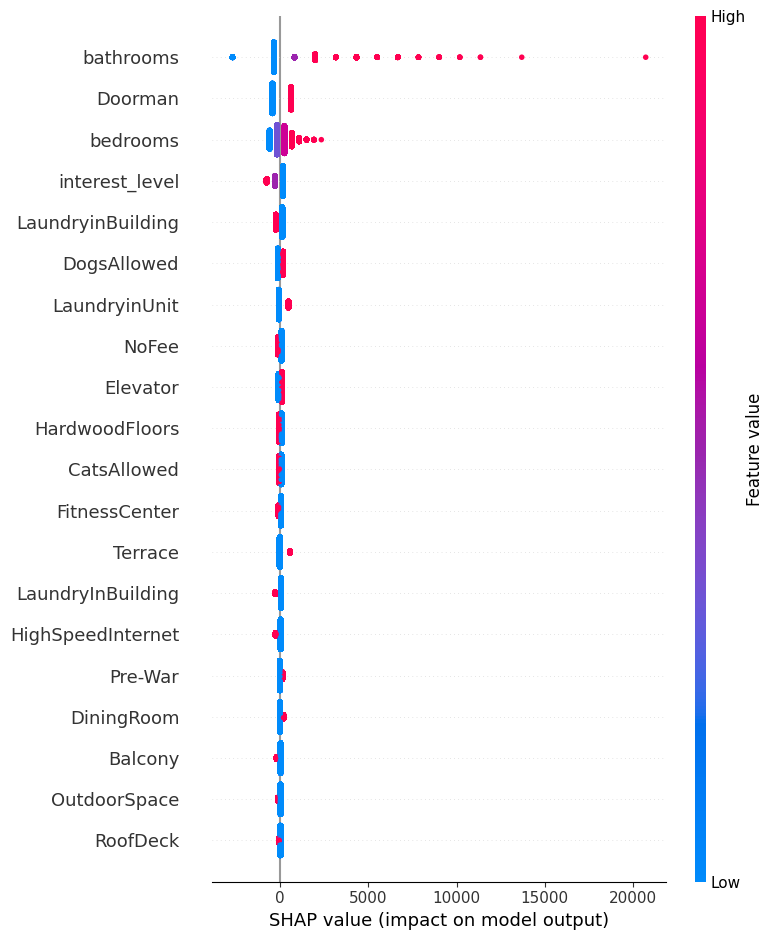

In [191]:
shap.summary_plot(shap_values, X_train.iloc[:, :(-1)], feature_names=X_train.columns[:(-1)])

In [192]:
top_10

array(['bathrooms', 'Doorman', 'bedrooms', 'interest_level',
       'LaundryinBuilding', 'DogsAllowed', 'LaundryinUnit', 'NoFee',
       'Elevator', 'HardwoodFloors'], dtype=object)

In [193]:
shap_X_train, shap_X_valid, shap_X_test = X_train[top_10].copy(), X_valid[top_10].copy(), X_test[top_10].copy()
shap_X_train["price"] = X_train["price"]
shap_X_valid["price"] = X_valid["price"]
shap_X_test["price"] = X_test["price"]

del X_train, X_valid, X_test

shap_X_train.head(3)

,bathrooms,Doorman,bedrooms,interest_level,LaundryinBuilding,DogsAllowed,LaundryinUnit,NoFee,Elevator,HardwoodFloors,price
0,-0.423163,1.166861,-0.485772,2.582781,-0.703671,-0.898132,-0.46384,-0.759766,0.950989,-0.954472,3195
1,-0.423163,-0.857000,-1.382628,0.985410,-0.703671,1.113422,-0.46384,1.316194,-1.051537,-0.954472,2000
2,1.571195,1.166861,1.307938,2.582781,-0.703671,1.113422,-0.46384,1.316194,0.950989,-0.954472,5850


In [194]:
model = Lasso()

model.fit(shap_X_train.iloc[:, :(-1)], shap_X_train.iloc[:, (-1)])

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [195]:
scorer = MetricsCalculator(shap_X_valid.iloc[:, :(-1)], shap_X_valid.iloc[:, (-1)])
scorer(model)

R2: 0.45396
MSE: 3.9174e+06
RMSE: 1979.2


Сравним теперь все способы выбора признаков по разным критериям:

1) **```Обучение на всех признаках```**

*Time*: 8.93 ms ± 128 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)<br>
*Metrics*:&emsp;&emsp;&ensp;```R2```: $0.45193$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```MSE```: $3.9319e+06$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```RMSE```: $1982.9$<br>
*Stability*: поскольку данные не меняют своё рапределение в выборках, то алгоритм работает стабильно

2) **```Обучение на 10 признаках с наибольшими по модулю коэффициентами w из модели```**

*Time*: 4.02 ms ± 920 μs per loop (mean ± std. dev. of 7 runs, 100 loops each) ```+``` 8.93 ms ± 128 μs per loop (mean ± std. dev. of 7 runs, 100 loops each) (поскольку для использования этого метода нужно обучить ещё одну модель на всех признаках)<br>
*Metrics*:&emsp;&emsp;&ensp;```R2```: $0.45397$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```MSE```: $3.9173e+06$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```RMSE```: $1979.2$<br>
*Stability*: поскольку данные не меняют своё рапределение в выборках, то алгоритм работает стабильно

3) **```Обучение на 10 признаках, для которых максимален Pearson's r и нет большого количества пропусков```**

*Time*: 62.9 ms ± 334 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)<br>
*Metrics*:&emsp;&emsp;&ensp;```R2```: $0.44909$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```MSE```: $3.9523e+06$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```RMSE```: $1988.0$<br>
*Stability*: поскольку данные не меняют своё рапределение в выборках, то алгоритм работает стабильно

4) **```Обучение на 10 признаках, выбранных с помощью Permutation Importance```**

*Time*: 205 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br>
*Metrics*:&emsp;&emsp;&ensp;```R2```: $0.44676$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```MSE```: $3.969e+06$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```RMSE```: $1992.2$<br>
*Stability*: алгоритм зависит от случайного разбиения (перемешивания) признаков внутри метода, поэтому состав признаков меняется и метрика получается разная

5) **```Обучение на 10 признаках, выбранных с помощью SHAP```**

*Time*: 25.8 ms ± 502 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)<br>
*Metrics*:&emsp;&emsp;&ensp;```R2```: $0.45396$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```MSE```: $3.9174e+06$<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;```RMSE```: $1979.2$<br>
*Stability*: поскольку данные не меняют своё рапределение в выборках, то алгоритм работает стабильно

***Вывод***: лучшими с точки зрения метрик качества оказались ```SHAP``` и метод, основанный на выборе признаков по величине модуля коэффициентов модели, второй из них работает немного быстрее. Худший результат как по времени, так и по метрикам и стабильности показал ```Permutation Importance```

## Hyperparameter optimization

In [196]:
class RangeValidator:
    def __set_name__(self, owner, name):
        self.name = "_" + name

    def __set__(self, instance, value):
        if not isinstance(value, np.ndarray):
            raise TypeError(f"{self.name} must be a numpy.ndarray object")
        elif len(value) == 0:
            raise ValueError(f"{self.name} must not be empty")
        elif np.any(value < 0):
            raise ValueError(f"{self.name} must contain non-negative values")

        setattr(instance, self.name, value)

    def __get__(self, instance, owner):
        return getattr(instance, self.name, None)


class ElNetGridSearch:
    alpha_range = RangeValidator()
    l1_range = RangeValidator()

    def __init__(self, alpha_range: np.ndarray, l1_range: np.ndarray):
        self.alpha_range = alpha_range
        self.l1_range = l1_range

    def __call__(self, train_features: pd.DataFrame, train_target: pd.Series, valid_features: pd.DataFrame, valid_target: pd.Series) -> tuple:
        self._validate_dataframe(train_features, "train_features", "ElNetGridSearch.__call__")
        self._validate_dataframe(valid_features, "valid_features", "ElNetGridSearch.__call__")
        self._validate_series(train_target, "train_target", "ElNetGridSearch.__call__")
        self._validate_series(valid_target, "valid_target", "ElNetGridSearch.__call__")

        best_comb, best_score = (self.alpha_range[0], self.l1_range[0]), float("inf")

        iter_num = len(self.alpha_range) * len(self.l1_range)
        
        with tqdm(total=iter_num, desc="Grid Search") as pbar: 
            for alpha in self.alpha_range:
                for l1_ratio in self.l1_range:
                    curr_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                    curr_model.fit(train_features, train_target)
    
                    curr_score = root_mean_squared_error(valid_target, curr_model.predict(valid_features))
                    if curr_score < best_score:
                        best_comb = tuple([alpha, l1_ratio])
                        best_score = curr_score

                    pbar.update(1)
                    
        print(f"Best score for the best combination: {best_score}")

        return best_comb

    @staticmethod
    def _validate_dataframe(df: pd.DataFrame, param_name: str, method_name: str) -> None:
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"{method_name}: Parameter '{param_name}' must be a pandas.DataFrame object")

    @staticmethod
    def _validate_series(series: pd.Series, param_name: str, method_name: str) -> None:
        if not isinstance(series, pd.Series):
            raise TypeError(f"{method_name}: Parameter '{param_name}' must be a pandas.Series object")

In [197]:
class ElNetRandomGridSearch(ElNetGridSearch):
    def __init__(self, n: int, alpha_range: np.ndarray, l1_range: np.ndarray):
        super().__init__(alpha_range, l1_range)
        self.n = n

    def __call__(self, train_features: pd.DataFrame, train_target: pd.Series, valid_features: pd.DataFrame, valid_target: pd.Series) -> tuple:
        self._validate_dataframe(train_features, "train_features", "ElNetRandomGridSearch.__call__")
        self._validate_dataframe(valid_features, "valid_features", "ElNetRandomGridSearch.__call__")
        self._validate_series(train_target, "train_target", "ElNetRandomGridSearch.__call__")
        self._validate_series(valid_target, "valid_target", "ElNetRandomGridSearch.__call__")
        
        combs = np.column_stack((np.random.choice(self.alpha_range, self.n), np.random.choice(self.l1_range, self.n)))
        best_comb, best_score = (combs[0][0], combs[0][1]), float("inf")
        with tqdm(total=self.n, desc="Randomized Grid Search") as pbar:
            for alpha, l1_ratio in combs:
                curr_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
                curr_model.fit(train_features, train_target)

                curr_score = root_mean_squared_error(valid_target, curr_model.predict(valid_features))
                if curr_score < best_score:
                    best_comb = (alpha, l1_ratio)
                    best_score = curr_score
                pbar.update(1)

        print(f"Best score for the best combination: {best_score}")
        return best_comb

    @property
    def n(self):
        return self._n

    @n.setter
    def n(self, n):
        if not isinstance(n, int):
            raise TypeError("Parameter n must be an integer")
        elif n < 1:
            raise ValueError("Parameter n must be at least 1")

        self._n = n

In [198]:
splitter = DateSplitterInN(3, dates)

X_train, X_valid, X_test = splitter(data, column_name="created", is_sorted=True)
X_train.drop("created", axis=1, inplace=True)
X_valid.drop("created", axis=1, inplace=True)
X_test.drop("created", axis=1, inplace=True)

print(len(X_train), len(X_valid), len(X_test))

29612 9870 9870


In [199]:
finder = ElNetGridSearch(np.arange(0.1, 100.1, 0.5), np.arange(0.1, 1.1, 0.1))
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])

Grid Search: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:18<00:00, 106.42it/s]

Best score for the best combination: 1979.340731507429


(np.float64(26.1), np.float64(1.0))

In [200]:
finder = ElNetGridSearch(np.arange(25.5, 26.51, 0.01), np.arange(0.1, 1.1, 0.1))
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])

Grid Search: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:04<00:00, 214.56it/s]

Best score for the best combination: 1979.340373298717


(np.float64(25.850000000000055), np.float64(1.0))

In [201]:
finder = ElNetRandomGridSearch(100, np.arange(0.1, 100.1, 0.1), np.arange(0.1, 1.00, 0.1))
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])
finder(X_train.iloc[:, :(-1)], X_train.iloc[:, -1], X_valid.iloc[:, :(-1)], X_valid.iloc[:, -1])

Random Grid Search: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 204.45it/s]


Best score for the best combination: 2032.368447820854


Random Grid Search: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 217.04it/s]


Best score for the best combination: 2013.1130806006026


Random Grid Search: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 222.14it/s]


Best score for the best combination: 2031.8452126441682


Random Grid Search: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 159.23it/s]


Best score for the best combination: 1984.073611371947


Random Grid Search: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 215.73it/s]

Best score for the best combination: 1996.8051971690325


(np.float64(1.8000000000000003), np.float64(0.9))

In [202]:
best_features

21            bathrooms
0               Doorman
22             bedrooms
20       interest_level
18        LaundryinUnit
7     LaundryinBuilding
8           DogsAllowed
9               Terrace
4                 NoFee
2              Elevator
Name: Feature, dtype: object

In [210]:
final_model = ElasticNet(alpha=25.85, l1_ratio=1)

final_model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, (-1)])

,alpha,25.85
,l1_ratio,1
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [211]:
scorer = MetricsCalculator(X_valid.iloc[:, :(-1)], X_valid.iloc[:, (-1)])
scorer(final_model)

R2: 0.4539
MSE: 3.9178e+06
RMSE: 1979.3


In [238]:
logging.getLogger("optuna").setLevel(logging.WARNING)

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.01, 100, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 1e-5, 1.0, log=True)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, (-1)])

    score = root_mean_squared_error(X_valid.iloc[:, (-1)], model.predict(X_valid.iloc[:, :(-1)]))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

Best trial: 44. Best value: 1983.23: 100%|█████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.39it/s]

Лучшие параметры модели: {'alpha': 0.01790231601022403, 'l1_ratio': 0.9164117467793095}
Лучший результат модели: 1983.2295547474173


In [224]:
logging.getLogger("optuna").setLevel(logging.WARNING)

param_grid = {"alpha": np.arange(0.1, 100.1, 0.5), "l1_ratio": np.arange(0.1, 1.1, 0.1)}

def objective(trial):
    alpha = trial.suggest_categorical("alpha", param_grid["alpha"])
    l1_ratio = trial.suggest_categorical("l1_ratio", param_grid["l1_ratio"])

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, (-1)])

    score = root_mean_squared_error(X_valid.iloc[:, (-1)], model.predict(X_valid.iloc[:, :(-1)]))
    
    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.GridSampler(param_grid))
study.optimize(objective, n_trials=len(param_grid["alpha"]) * len(param_grid["l1_ratio"]), show_progress_bar=True)

print("Лучшие параметры модели:", study.best_params)
print("Лучший результат модели (RMSE):", study.best_value)

Best trial: 503. Best value: 1979.34: 100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:10<00:00,  2.98it/s]

Лучшие параметры модели: {'alpha': np.float64(26.1), 'l1_ratio': np.float64(1.0)}
Лучший результат модели (RMSE): 1979.340731507429


In [233]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 100)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_train.iloc[:, :(-1)], X_train.iloc[:, -1])

    score = root_mean_squared_error(X_valid.iloc[:, (-1)], model.predict(X_valid.iloc[:, :(-1)]))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=75)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

Лучшие параметры модели: {'alpha': 0.5118340313798223, 'l1_ratio': 0.9355117907491549}
Лучший результат модели: 1983.7522510927263


**Сравнение методов:**

1) Результат ```GridSearch``` оказался *одинаковым*, однако время работы собственной реализации ```GridSearch``` существенно меньше, чем его реализации в ```optuna```
2) В отличие от ```GridSearch```, в ```Randomized Grid Search``` практически нет отличий во времени работы алгоритма. Очевидно, что сравнивать результаты не имеет смысла, поскольку это случайные процессы

In [237]:
logging.getLogger("optuna").setLevel(logging.WARNING)

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 100)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    score = ms.cross_val_score(model, X_valid.iloc[:, :(-1)], X_valid.iloc[:, (-1)], cv=5, scoring="neg_root_mean_squared_error", n_jobs=(-1)).mean()

    return -score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=75, show_progress_bar=True)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

Best trial: 8. Best value: 1915.03: 100%|██████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:14<00:00,  5.33it/s]

Лучшие параметры модели: {'alpha': 0.12096646519156135, 'l1_ratio': 0.6430146324726161}
Лучший результат модели: 1915.0285701775897
